# Error Allocation vs. SGD

### Pre-requirements
- PyTorch
- NumPy
- Sci-Kit Learn

### Dataset
Iris:
- 100 train samples
- 50 test samples

In [1]:
import torch
import torch.nn as nn
import numpy as np 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_set = load_iris()
X = iris_set.data
y_ = iris_set.target

# Convert to One-Hot label
y = np.zeros((len(y_), 3))
y[np.arange(len(y_)), y_] = 1


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
y_ = torch.from_numpy(y_).long()


X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [2]:
def model_gen():
    model = nn.Sequential(
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 3)
    )

    # loss_func = nn.CrossEntropyLoss() 
    loss_func = nn.MSELoss()
    
    return model, loss_func

In [3]:
### PyTorch Built-in SGD
model, loss_func = model_gen()
optim = torch.optim.SGD(model.parameters(), lr=0.2)


SGD_err_list = list()
SGD_test_errs = list()
for ep in range(200):
    y_hat = model(X_train)
    # For MSELoss
    curr_err = loss_func(y_hat, y_train)
    
    curr_err.backward()
    SGD_err_list.append(curr_err.item())
    
    y_test_hat = model(X_test)
    SGD_test_errs.append(loss_func(y_test_hat, y_test).item())
    
    # PyTorch Optimization
    optim.step()
    optim.zero_grad()
    

In following part, `err_alloc` means the allocation coefficient to different layers. In form of `[Layer1.weight, Layer1.bias, Layer2.weight, Layer2. bias ...]`. Note that, this explanation only works when all the layers are `Linear` layer. Because `Linear.parameters()` is `[Weights, Biases]`. And `model.parameters()` return all the parameters for each layers (maybe `Conv2D`) in order.

In [4]:
### Error Allocation
model, loss_func = model_gen()
lr = 0.1
EA_err_list = list()
EA_test_errs = list()
for ep in range(200):
    y_hat = model(X_train)
    
    # For MSELoss
    curr_err = loss_func(y_hat, y_train)
    
    curr_err.backward()
    EA_err_list.append(curr_err.item())
    
    y_test_hat = model(X_test)
    EA_test_errs.append(loss_func(y_test_hat, y_test).item())   
    
    with torch.no_grad():
        count = 0
        # the average of coefficient is same with the learning rate of SGD
        err_alloc = [3, 3, 2, 2, 1, 1]
        for param in model.parameters():
            param -= err_alloc[count] * param.grad * lr 
            count += 1

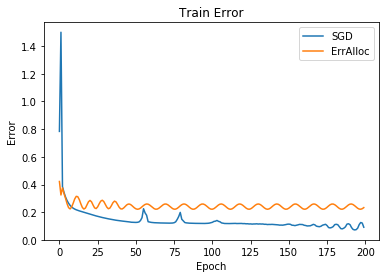

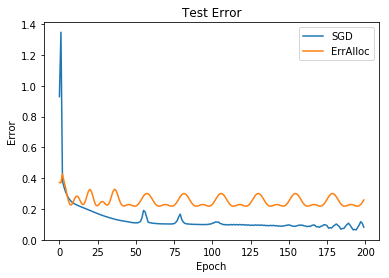

In [6]:
# Visualize the Train and test error
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(SGD_err_list)), SGD_err_list, label='SGD')
plt.plot(range(len(EA_err_list)), EA_err_list, label='ErrAlloc')
plt.title('Train Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.figure()
plt.plot(range(len(SGD_test_errs)), SGD_test_errs, label='SGD')
plt.plot(range(len(EA_test_errs)), EA_test_errs, label='ErrAlloc')
plt.title('Test Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.show()